In [1]:
# загрузка пакетов: инструменты -------------------------------------------- # работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели ------------------------------------------------- # стандартизация показателей
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
# логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV # перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
# расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# константы
# ядро для генератора случайных чисел
my_seed = 11
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [3]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
# из репозитория к книге С.Рашки Python и машинное обучение,
# слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure() # палитра
    ax = plt.subplot(111)

    colors = sns.color_palette("Spectral", len(col_names)-1)
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, C=10.**c, solver='liblinear',multi_class='ovr', random_state=my_seed)
        lr.fit(X,y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)
    weights = np.array(weights)
    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column], label=col_names[column], color=color)
# отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
    plt.show()

In [4]:
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/winequality-white_for_lab.csv'

DF_all = pd.read_csv(fileURL)

DF_1 = DF_all[['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides','free_sulfur_dioxide','pH','sulphates','alcohol','Y']]
    

In [5]:
# наблюдения для моделирования
DF = DF_1.sample(frac = 0.85, random_state = my_seed) # отложенные наблюдения
DF_predict = DF_1.drop(DF.index)

In [6]:
# считаем пропуски в каждом столбце
DF.isna().sum()

fixed_acidity          0
volatile_acidity       0
citric_acid            0
residual_sugar         0
chlorides              0
free_sulfur_dioxide    0
pH                     0
sulphates              0
alcohol                0
Y                      0
dtype: int64

Пропусков в таблице нет

In [7]:
# типы столбцов фрейма
DF.dtypes

fixed_acidity          float64
volatile_acidity       float64
citric_acid            float64
residual_sugar         float64
chlorides              float64
free_sulfur_dioxide    float64
pH                     float64
sulphates              float64
alcohol                float64
Y                        int64
dtype: object

Все переменные имеют числовой тип

## Предварительный анализ данных

### Описательные статистики

In [8]:
# метки классов
DF.Y.unique()


array([1, 0], dtype=int64)

Всего целевых класса два: 0 и 1

In [9]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

1    0.663
0    0.337
Name: Y, dtype: float64

Класс 1 занимает большую долю в отличии от класса 0. 

In [10]:
# описательные статистики
DF.iloc[:, :6].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,6.857579,0.278273,0.334432,6.380339,0.045989,35.371847
std,0.852259,0.100381,0.121975,5.072203,0.022306,17.166066
min,3.800000,0.080000,0.000000,0.600000,0.012000,2.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000
75%,7.300000,0.320000,0.390000,9.850000,0.050000,46.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000


In [11]:
# описательные статистики
DF.iloc[:, 6:11].describe()

,pH,sulphates,alcohol,Y
count,4163.000000,4163.000000,4163.000000,4163.000000
mean,3.189743,0.489793,10.511633,0.662983
std,0.151353,0.114194,1.233618,0.472747
min,2.720000,0.220000,8.000000,0.000000
25%,3.090000,0.410000,9.500000,0.000000
50%,3.180000,0.470000,10.400000,1.000000
75%,3.280000,0.550000,11.400000,1.000000
max,3.820000,1.060000,14.050000,1.000000


Выводы по описательным статистикам: значения объясняющих переменных положительные, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.


### Визуализация разброса переменных внутри классов

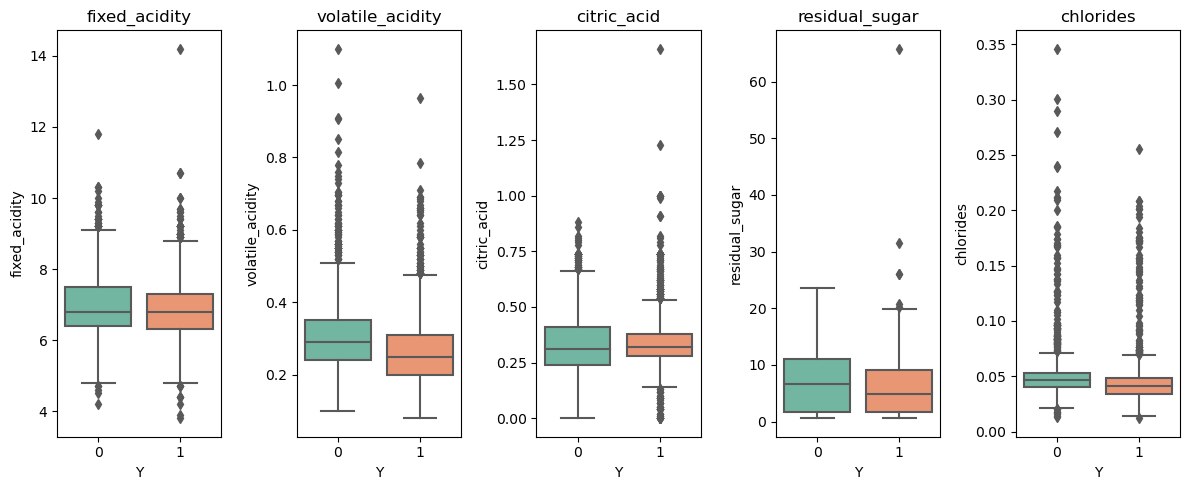

In [12]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
  i = cols_loop.index(col_name)
  sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
  axs[i].set_ylabel(col_name)
  axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

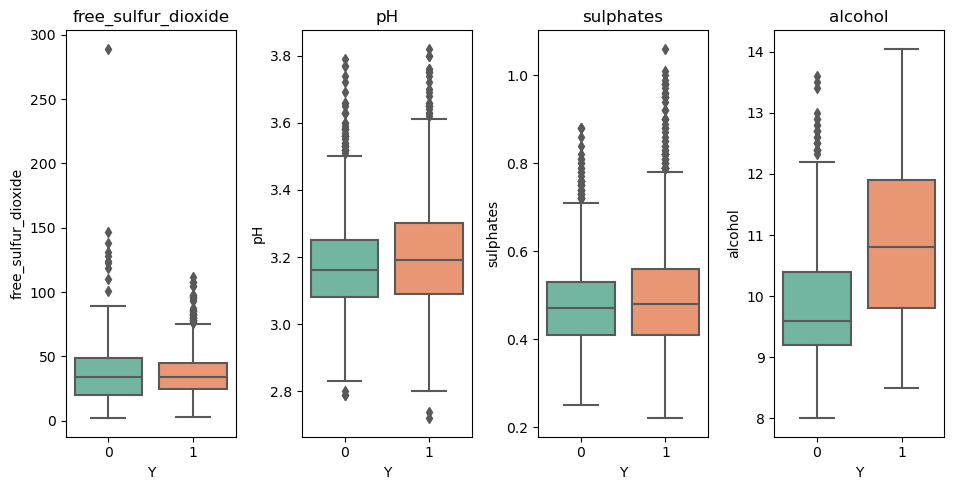

In [13]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

axs = [ax1, ax2, ax3, ax4]
cols_loop = list(DF.columns[5:9].values)
for col_name in cols_loop :
  i = cols_loop.index(col_name)
  sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
  axs[i].set_ylabel(col_name)
  axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в медианах и разбросе между классами прослеживается практически по всем объясняющим переменным. Меньше всего различаются коробчатые диаграммы по переменной fixed_acidity, chlorides, free_sulfur_dioxide, volatile_acidity. 

## Корреляционный анализ

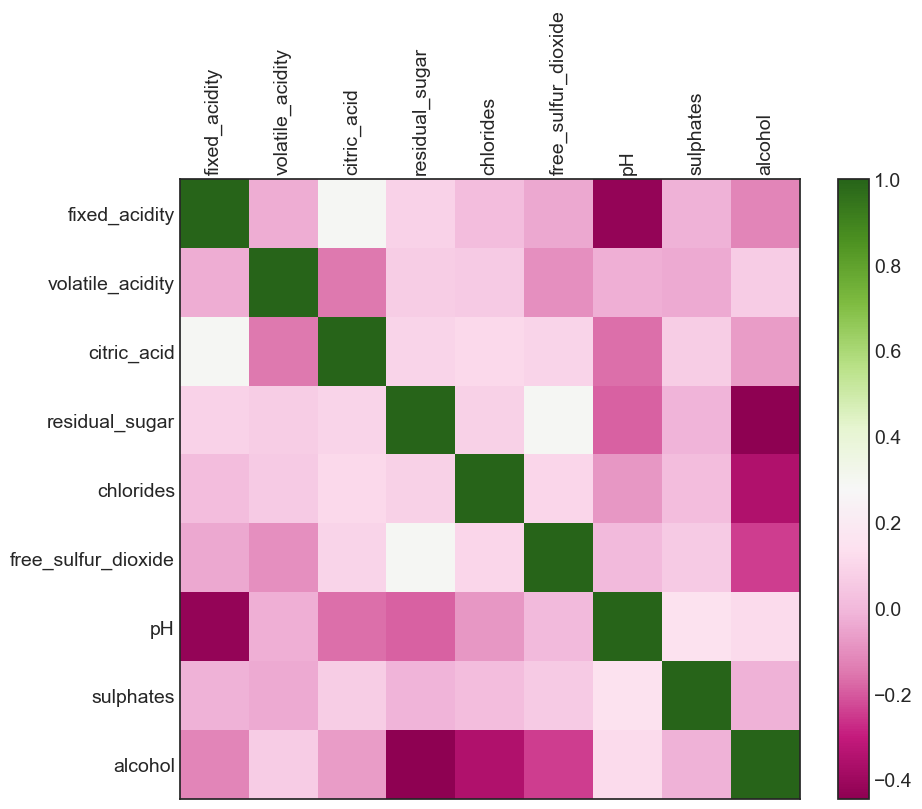

In [14]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns
# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')
# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них

In [15]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения # и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция.values ** 2))
df['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
# выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
25,residual_sugar,alcohol,-0.445075,0.0
5,fixed_acidity,pH,-0.428127,0.0
29,chlorides,alcohol,-0.354432,0.0
32,free_sulfur_dioxide,alcohol,-0.243405,0.0
23,residual_sugar,pH,-0.185970,0.0
18,citric_acid,pH,-0.168148,0.0
8,volatile_acidity,citric_acid,-0.150760,0.0
7,fixed_acidity,alcohol,-0.120636,0.0
11,volatile_acidity,free_sulfur_dioxide,-0.096637,0.0
27,chlorides,pH,-0.082167,0.0


## Методы снижения резмерности (PCR)

In [16]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :10].values)
# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
  print('Столбец ', i_col, ': среднее = ',
  np.round(np.mean(X_train_std[:, i_col]), 2), ' Станд. отклонение = ',
  np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0 Станд. отклонение = 1.0
Столбец 1: среднее = -0.0 Станд. отклонение = 1.0
Столбец 2: среднее = 0.0 Станд. отклонение = 1.0
Столбец 3: среднее = 0.0 Станд. отклонение = 1.0
Столбец 4: среднее = -0.0 Станд. отклонение = 1.0
Столбец 5: среднее = 0.0 Станд. отклонение = 1.0
Столбец 6: среднее = 0.0 Станд. отклонение = 1.0
Столбец 7: среднее = -0.0 Станд. отклонение = 1.0
Столбец 8: среднее = 0.0 Станд. отклонение = 1.0
Столбец 9: среднее = 0.0 Станд. отклонение = 1.0


### Регрессия на главные компоненты (PCR)

In [17]:
# функция с методом главных компонент
pca = PCA()
# пересчитываем в главные компоненты (ГК)
X_train_pca = pca.fit_transform(X_train_std)
# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
np.around(frac_var_expl, 3),'\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.211 0.147 0.135 0.105 0.094 0.081 0.074 0.066 0.052 0.035] 
Общая сумма долей: 1.0


In [18]:
# ГК ортогональны – убедимся в этом, рассчитыв корреляционную матрицу
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
1,0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
2,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0
5,0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0
6,0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0,-0.0
7,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,1.0,-0.0
9,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0


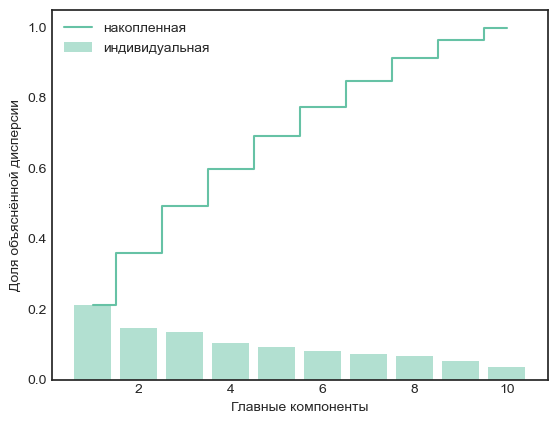

In [19]:
# график объяснённой дисперсии
plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.5, align='center', label='индивидуальная')
plt.step(range(1, 11), np.cumsum(pca.explained_variance_ratio_),
 where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()


Столбцы на графике показывают долю исходной дисперсии исходных переменных, которую объясняет главная компонента. Линией показана накопленная доля. Так, видно, что первые 5
компонент объясняют 80% исходной дисперсии .
Чтобы увидеть, как классы выглядят в координатах ГК на графике, придётся сократить пространство для дву компонент, которые объясняют 36% разброса объясняющих переменных.

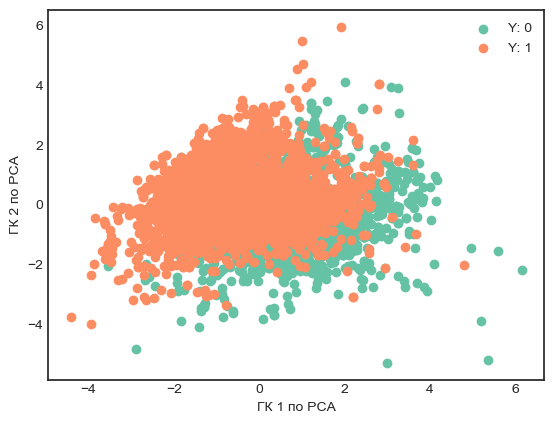

In [20]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)

# график классов в пространстве ГК
plt.scatter(X_train_pca[DF['Y'] == 0][:, 0], X_train_pca[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pca[DF['Y'] == 1][:, 0], X_train_pca[DF['Y'] == 1][:, 1], label='Y: 1')
plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')

plt.legend()
plt.show()

Судя по графику, классы плохо разделяются в пространстве двух главных компонент. Построим логистическую регрессию и оценим её точность с помощью перекрёстной проверки.

In [21]:
# функция оценки логистической регрессии
logit = LogisticRegression()
# функция разбиения на блоки для перекрёстной проверки
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
score = list()
acc = cross_val_score(logit, X_train_pca, DF.Y.values, cv=kf_10,
scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам','\nAcc = ', np.around(score[0], 2), sep='')
     

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.76


## Методы сжатия (Ридж-регрессия)

In [22]:
# функция для построения модели
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear') # оцениваем параметры
logit_ridge.fit(X_train_std, DF.Y.values)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3), '\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))

Константы моделей для классов:
 [2.134] 
Коэффициенты моделей для классов:
 [[-0.064 -0.248  0.012  0.086 -0.042  0.047  0.007  0.06   0.422  5.986]]


In [23]:
# поиск оптимального значения C:
# подбираем C по наибольшей точности с перекрёстной проверкой
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2,penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, DF.Y.values)
# значения параметра C (инверсия лямбды), которые дают наилучшую # точность для каждого класса
ridge_cv.C_

array([0.00599484])

In [24]:
score.append(np.around(ridge_cv.score(X_train_std, DF.Y.values), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам','\nAcc = ', score[1], sep='')
     

Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 1.0


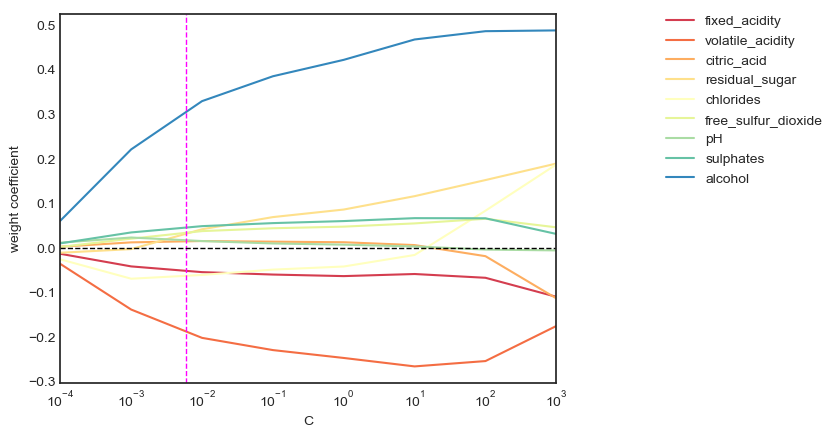

In [25]:
# график динамики коэффициентов в ридж-регрессии
# модель для класса 0
plot_coeffs_traces(X_train_std, DF.Y.values, 0, 'l2', ridge_cv.C_, DF.columns)  

Из-за того, что классы 0 и 1 в Y не сбалансированы, ридж-регрессия увидела только один из классов и была построена на нем

In [26]:
#очность построенных моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PC2,0.759
1,logit_ridge,1.000


In [27]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :10].values)
Y_pred = DF_predict.Y
Y_hat = logit_ridge.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       237
           1       1.00      1.00      1.00       498

    accuracy                           1.00       735
   macro avg       1.00      1.00      1.00       735
weighted avg       1.00      1.00      1.00       735



методом логистической регрессии мы получили идеально точную модель классификации Y по двум классам